In [344]:
%%bash
cd /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts
echo "Running evaluation sweep for unstructured sparse architecture"
chmod +x sweep1.sh
time ./sweep1.sh

Running evaluation sweep for unstructured sparse architecture
Processing resnet50_conv1 with unstructured_sparse_tensor_core...
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
Found Accelergy ERT (energy reference table), replacing internal energy model.
Found Accelergy ART (area reference table), replacing internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using all available hardware threads = 11
Mapper configuration complete.
Initializing Index Factorization subspace.
  Factorization options along problem dimension C = 6
  Factorization options along problem dimension M = 462
  Factorization options along problem dimension R = 6
  Factorization options along problem dimension S = 6
  Fact

[  3] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  9] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  7] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  2] Utilization = 0.00 | pJ/Compute =  128.229 | L3[WIO] Q1 - L2[] Q1 - L1[] C3 - L0[] Q112 P112 S7 R7 M64 
[  4] Utilization = 0.00 | pJ/Compute =  128.229 | L3[WIO] Q1 - L2[] C3 - L1[] Q1 - L0[] Q112 P112 S7 R7 M64 
[  1] Utilization = 0.01 | pJ/Compute =   85.563 | L3[WIO] Q1 - L2[] Q1 - L1[] Q1 C3Y - L0[] Q112 P112 S7 R7 M64 
[  8] Utilization = 0.20 | pJ/Compute =   45.372 | L3[WIO] M2 - L2[] P2 M2Y - L1[] Q14 M4 C3 R7Y M4X - L0[] Q8 P56 S7 
[ 10] Utilization = 0.20 | pJ/Compute =   45.372 | L3[WIO] M2 - L2[] P2 C3 M2Y - L1[] Q14 M4 R7Y M4X - L0[] Q8 P56 S7 
[  5] Utilization = 0.00 | pJ/Compute =  128.229 | L3[WIO] C3 - L

[  2] Utilization = 0.11 | pJ/Compute =   12.053 | L3[WIO] M2 - L2[I] P2 M2Y - L1[W] Q14 M4 C3 R7Y M2X - L0[] Q8 P56 S7 M2 
[  5] Utilization = 0.11 | pJ/Compute =   11.521 | L3[WIO] M2 C3 - L2[O] P2 M2Y - L1[W] Q14 M4 R7Y M2X - L0[] Q8 P56 S7 M2 
[  2] Utilization = 0.11 | pJ/Compute =   11.521 | L3[WIO] M2 - L2[O] P2 M2Y - L1[W] Q14 M4 C3 R7Y M2X - L0[] Q8 P56 S7 M2 
[  4] Utilization = 0.11 | pJ/Compute =   11.523 | L3[WIO] M2 - L2[O] P2 C3 M2Y - L1[W] Q14 M4 R7Y M2X - L0[] Q8 P56 S7 M2 
[  1] Utilization = 0.19 | pJ/Compute =   43.277 | L3[WIO] M2 - L2[] P2 M2Y - L1[] Q14 M4 R7Y M2X C3X - L0[] Q8 P56 S7 M2 
[  1] Utilization = 0.33 | pJ/Compute =   12.862 | L3[WIO] M2 - L2[] P2 M2Y - L1[W] Q14 M4 R7Y M2X C3X - L0[] Q8 P56 S7 M2 
[  5] Utilization = 0.11 | pJ/Compute =    4.665 | L3[WIO] M2 C3 - L2[IO] P2 M2Y - L1[W] Q14 M4 R7Y M2X - L0[] Q8 P56 S7 M2 
[  2] Utilization = 0.11 | pJ/Compute =    4.617 | L3[WIO] M2 - L2[IO] P2 M2Y - L1[W] Q14 M4 C3 R7Y M2X - L0[] Q8 P56 S7 M2 
[  4] U



Summary stats for best mapping found by mapper:
  Utilization = 0.33 | pJ/Compute =    3.771
Processing alexnet_conv1_sparse with unstructured_sparse_tensor_core...
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
Found Accelergy ERT (energy reference table), replacing internal energy model.
Found Accelergy ART (area reference table), replacing internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using all available hardware threads = 11
Mapper configuration complete.
Initializing Index Factorization subspace.
  Factorization options along problem dimension C = 6
  Factorization options along problem dimension M = 1512
  Factorization options along problem dimension R = 6
  Factorization opti

[  3] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[ 10] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  7] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  6] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  9] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  8] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  2] Utilization = 0.00 | pJ/Compute =  128.359 | L3[WIO] Q1 - L2[] Q1 - L1[] C3 - L0[] Q56 P56 N4 S11 R11 M96 
[  4] Utilization = 0.00 | pJ/Compute =  128.359 | L3[WIO] Q1 - L2[] C3 - L1[] Q1 - L0[] Q56 P56 N4 S11 R11 M96 
[  1] Utilization = 0.01 | pJ/Compute =   85.692



Summary stats for best mapping found by mapper:
  Utilization = 0.01 | pJ/Compute =   11.927
Processing mobilenet_conv1_sparse with unstructured_sparse_tensor_core...
  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
Found Accelergy ERT (energy reference table), replacing internal energy model.
Found Accelergy ART (area reference table), replacing internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using all available hardware threads = 11
Mapper configuration complete.
Initializing Index Factorization subspace.
  Factorization options along problem dimension R = 6
  Factorization options along problem dimension S = 6
  Factorization options along problem dimension E = 756
  Factorization opt

[  3] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  9] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  0] Utilization = 0.00 | pJ/Compute =  127.262 | L3[WIO] G1 - L2[] G1 - L1[] G1 - L0[] M32 C3 F112 E112 S3 R3 
[  6] Utilization = 0.01 | pJ/Compute =   84.595 | L3[WIO] G1 - L2[] G1 - L1[] G1 S3Y - L0[] M32 C3 F112 E112 R3 
[ 10] Utilization = 0.01 | pJ/Compute =   84.595 | L3[WIO] G1 - L2[] R3 - L1[] G1 S3Y - L0[] M32 C3 F112 E112 
[  8] Utilization = 0.01 | pJ/Compute =   84.595 | L3[WIO] G1 - L2[] G1 - L1[] R3 S3Y - L0[] M32 C3 F112 E112 
[  5] Utilization = 0.00 | pJ/Compute =  127.262 | L3[WIO] R3 - L2[] G1 - L1[] G1 - L0[] M32 C3 F112 E112 S3 
[  1] Utilization = 0.01 | pJ/Compute =   84.595 | L3[WIO] G1 - L2[] G1 - L1[] G1 R3Y - L0[] M32 C3 F112 E112 S3 
[  4] Utilization = 0.00 | pJ/Compute =  127.262 | L3[WIO] G1 - L2[] R3 - L1[] G1 - L



Summary stats for best mapping found by mapper:
  Utilization = 0.04 | pJ/Compute =    8.541



real	0m1.631s
user	0m4.280s
sys	0m0.155s


In [345]:
%%bash
cd /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts && \
chmod +x parse_and_plot1.py && \
time ./parse_and_plot1.py


Summary Statistics:

Unstructured Sparse Architecture:
resnet50_conv1:
  Cycles: 1,404,928
  Energy: 445,080,000.0 pJ
  Utilization: 33.00%
alexnet_conv1_sparse:
  Cycles: 145,711,104
  Energy: 5,213,610,000.0 pJ
  Utilization: 1.00%
mobilenet_conv1_sparse:
  Cycles: 1,204,224
  Energy: 92,570,000.0 pJ
  Utilization: 4.00%
Unstructured sparse architecture plots created successfully!



real	0m1.383s
user	0m2.841s
sys	0m3.815s


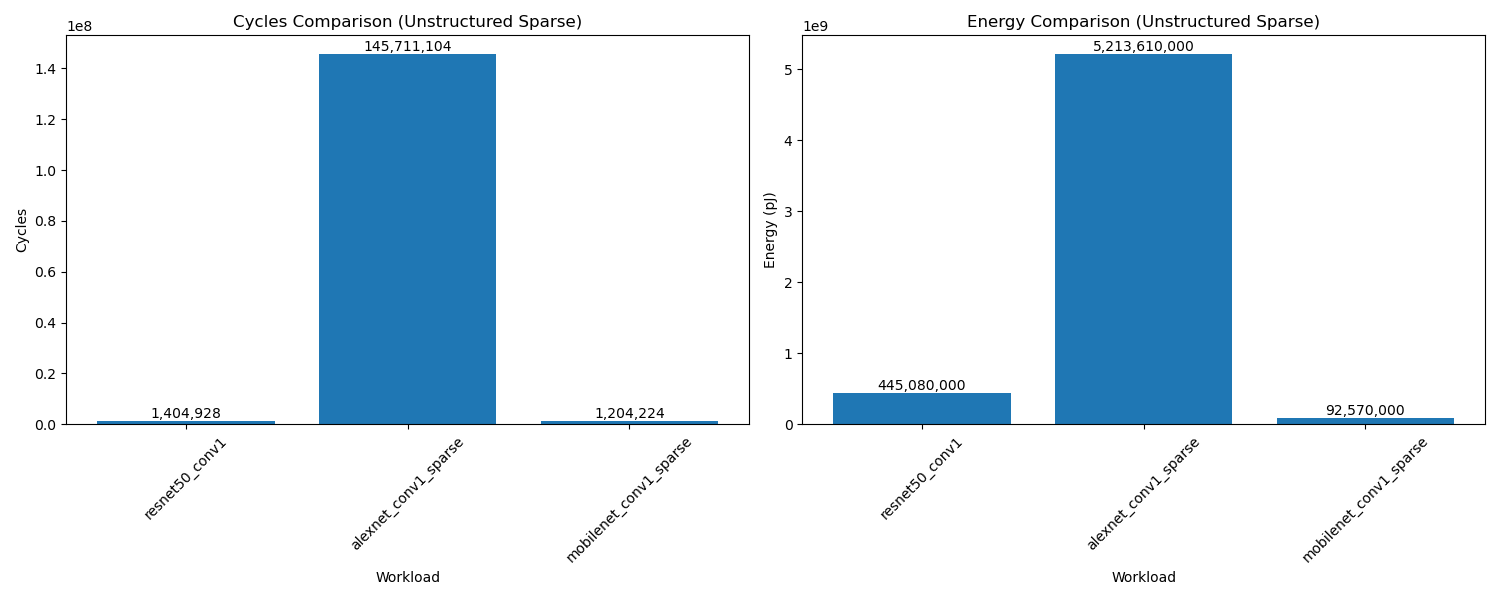

In [346]:
from IPython.display import Image
import matplotlib.pyplot as plt

# Define path to the figure using the absolute path
unstructured_comparison_fig = "../evaluation_setups/unstructured_sparse_eval/outputs/figures/unstructured_comparison.png"
# Display the image directly using IPython's Image display
Image(filename=unstructured_comparison_fig)

In [347]:
%%bash
cd /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts
echo "Running evaluation sweep for unstructured spares architecture with no overhead"
chmod +x sweep2.sh
time ./sweep2.sh

Running evaluation sweep for unstructured spares architecture with no overhead


+ WORKLOADS=("resnet50_conv1" "alexnet_conv1_sparse" "mobilenet_conv1_sparse")
+++ dirname ./sweep2.sh
++ cd .
++ pwd
+ SCRIPT_DIR=/home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts
++ dirname /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts
+ BASE_DIR=/home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval
+ echo 'Script directory: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts'


Script directory: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts
Base directory: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval


+ echo 'Base directory: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval'
++ pwd
+ echo 'Current directory: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts'
+ echo 'Contents of script directory:'


Current directory: /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts
Contents of script directory:


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts


total 40
drwxr-xr-x  8 workspace workspace  256 Apr 24 02:25 .
drwxr-xr-x 10 workspace workspace  320 Apr 24 01:54 ..
-rwxr-xr-x  1 workspace workspace 4533 Apr 24 02:26 parse_and_plot1.py
-rwxr-xr-x  1 workspace workspace 4340 Apr 24 02:26 parse_and_plot2.py
-rwxr-xr-x  1 workspace workspace 7558 Apr 24 01:34 parse_and_plot_m2.py
-rwxr-xr-x  1 workspace workspace  986 Apr 24 02:59 sweep1.sh
-rwxr-xr-x  1 workspace workspace 1779 Apr 24 02:59 sweep2.sh
-rwxr-xr-x  1 workspace workspace 4164 Apr 24 01:34 sweep_m2.sh


+ echo 'Contents of base directory:'
+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval


Contents of base directory:
total 0
drwxr-xr-x 10 workspace workspace 320 Apr 24 01:54 .
drwxr-xr-x  9 workspace workspace 288 Apr 13 06:57 ..
drwxr-xr-x  6 workspace workspace 192 Apr 24 02:21 arch
drwxr-xr-x  3 workspace workspace  96 Apr 24 01:34 dataflow
drwxr-xr-x  6 workspace workspace 192 Apr 24 02:16 ert_art
drwxr-xr-x  3 workspace workspace  96 Apr 24 01:34 mapper
drwxr-xr-x  9 workspace workspace 288 Apr 24 02:38 outputs
drwxr-xr-x  8 workspace workspace 256 Apr 24 02:25 scripts
drwxr-xr-x  5 workspace workspace 160 Apr 24 02:15 sparse-opt
drwxr-xr-x  8 workspace workspace 256 Apr 24 01:34 workload


+ which timeloop-mapper


/usr/local/bin/timeloop-mapper


+ timeloop-mapper --version
ERROR: Input configuration file does not end with .cfg, .yml, or .yaml
+ for workload in "${WORKLOADS[@]}"
+ echo 'Processing resnet50_conv1 with ideal_sparse_tensor_core...'
+ mkdir -p /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/ideal_resnet50_conv1


Processing resnet50_conv1 with ideal_sparse_tensor_core...


+ echo 'Checking required files:'
+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/arch/unstructured_sparse_tensor_core_ideal.yaml


Checking required files:
-rw-r--r-- 1 workspace workspace 3920 Apr 24 02:45 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/arch/unstructured_sparse_tensor_core_ideal.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/dataflow/weight_stationary.yaml


-rw-r--r-- 1 workspace workspace 425 Apr 24 01:34 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/dataflow/weight_stationary.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/sparse-opt/unstructured.yaml


-rw-r--r-- 1 workspace workspace 241 Apr 24 03:03 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/sparse-opt/unstructured.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/workload/resnet50_conv1.yaml


-rw-r--r-- 1 workspace workspace 1010 Apr 24 03:02 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/workload/resnet50_conv1.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/mapper/mapper.yaml


-rw-r--r-- 1 workspace workspace 606 Apr 24 02:39 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/mapper/mapper.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ART.yaml


-rw-r--r-- 1 workspace workspace 312 Apr 24 01:34 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ART.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ERT_ideal.yaml


-rw-r--r-- 1 workspace workspace 2190 Apr 24 03:05 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ERT_ideal.yaml


+ timeloop-mapper /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/arch/unstructured_sparse_tensor_core_ideal.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/dataflow/weight_stationary.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/sparse-opt/unstructured.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/workload/resnet50_conv1.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/mapper/mapper.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ERT_ideal.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ART.yaml -o /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/ideal_resnet50_conv1


  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
Found Accelergy ERT (energy reference table), replacing internal energy model.
Found Accelergy ART (area reference table), replacing internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using all available hardware threads = 11
Mapper configuration complete.
Initializing Index Factorization subspace.
  Factorization options along problem dimension C = 6
  Factorization options along problem dimension M = 462
  Factorization options along problem dimension R = 6
  Factorization options along problem dimension S = 6
  Factorization options along problem dimension N = 1
  Factorization options along problem dimension P = 756
  Factorization options 

[  7] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  9] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  3] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  2] Utilization = 0.00 | pJ/Compute =  127.782 | L3[WIO] Q1 - L2[] Q1 - L1[] C3 - L0[] Q112 P112 S7 R7 M64 
[  4] Utilization = 0.00 | pJ/Compute =  127.782 | L3[WIO] Q1 - L2[] C3 - L1[] Q1 - L0[] Q112 P112 S7 R7 M64 
[  1] Utilization = 0.01 | pJ/Compute =   85.116 | L3[WIO] Q1 - L2[] Q1 - L1[] Q1 C3Y - L0[] Q112 P112 S7 R7 M64 
[  8] Utilization = 0.20 | pJ/Compute =   44.925 | L3[WIO] M2 - L2[] P2 M2Y - L1[] Q14 M4 C3 R7Y M4X - L0[] Q8 P56 S7 
[ 10] Utilization = 0.20 | pJ/Compute =   44.925 | L3[WIO] M2 - L2[] P2 C3 M2Y - L1[] Q14 M4 R7Y M4X - L0[] Q8 P56 S7 
[  5] Utilization = 0.00 | pJ/Compute =  127.782 | L3[WIO] C3 - L

[  4] Utilization = 0.11 | pJ/Compute =    4.171 | L3[WIO] M2 - L2[WIO] P2 C3 M2Y - L1[W] Q14 M4 R7Y M2X - L0[] Q8 P56 S7 M2 
[  0] Utilization = 0.11 | pJ/Compute =    4.170 | L3[WIO] M2 - L2[IO] P2 M2Y - L1[W] Q14 M4 R7Y M2X - L0[] Q8 P56 S7 M2 C3 
[  5] Utilization = 0.11 | pJ/Compute =   48.925 | L3[WIO] M2 C3 - L2[] P2 M2Y - L1[] Q14 M4 R7Y M2X - L0[] Q8 P56 S7 M2 
[  5] Utilization = 0.11 | pJ/Compute =   18.510 | L3[WIO] M2 C3 - L2[] P2 M2Y - L1[W] Q14 M4 R7Y M2X - L0[] Q8 P56 S7 M2 
[  2] Utilization = 0.11 | pJ/Compute =   11.074 | L3[WIO] M2 - L2[O] P2 M2Y - L1[W] Q14 M4 C3 R7Y M2X - L0[] Q8 P56 S7 M2 
[  5] Utilization = 0.11 | pJ/Compute =   11.655 | L3[WIO] M2 C3 - L2[I] P2 M2Y - L1[W] Q14 M4 R7Y M2X - L0[] Q8 P56 S7 M2 
[  2] Utilization = 0.11 | pJ/Compute =    4.170 | L3[WIO] M2 - L2[IO] P2 M2Y - L1[W] Q14 M4 C3 R7Y M2X - L0[] Q8 P56 S7 M2 
[  5] Utilization = 0.11 | pJ/Compute =   11.074 | L3[WIO] M2 C3 - L2[O] P2 M2Y - L1[W] Q14 M4 R7Y M2X - L0[] Q8 P56 S7 M2 
[  5] U



Summary stats for best mapping found by mapper:
  Utilization = 0.22 | pJ/Compute =    2.076


+ for workload in "${WORKLOADS[@]}"
+ echo 'Processing alexnet_conv1_sparse with ideal_sparse_tensor_core...'


Processing alexnet_conv1_sparse with ideal_sparse_tensor_core...


+ mkdir -p /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/ideal_alexnet_conv1_sparse
+ echo 'Checking required files:'
+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/arch/unstructured_sparse_tensor_core_ideal.yaml


Checking required files:
-rw-r--r-- 1 workspace workspace 3920 Apr 24 02:45 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/arch/unstructured_sparse_tensor_core_ideal.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/dataflow/weight_stationary.yaml


-rw-r--r-- 1 workspace workspace 425 Apr 24 01:34 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/dataflow/weight_stationary.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/sparse-opt/unstructured.yaml


-rw-r--r-- 1 workspace workspace 241 Apr 24 03:03 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/sparse-opt/unstructured.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/workload/alexnet_conv1_sparse.yaml


-rw-r--r-- 1 workspace workspace 990 Apr 24 03:03 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/workload/alexnet_conv1_sparse.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/mapper/mapper.yaml


-rw-r--r-- 1 workspace workspace 606 Apr 24 02:39 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/mapper/mapper.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ART.yaml


-rw-r--r-- 1 workspace workspace 312 Apr 24 01:34 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ART.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ERT_ideal.yaml


-rw-r--r-- 1 workspace workspace 2190 Apr 24 03:05 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ERT_ideal.yaml


+ timeloop-mapper /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/arch/unstructured_sparse_tensor_core_ideal.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/dataflow/weight_stationary.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/sparse-opt/unstructured.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/workload/alexnet_conv1_sparse.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/mapper/mapper.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ERT_ideal.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ART.yaml -o /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/ideal_alexnet_conv1_sparse


  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
Found Accelergy ERT (energy reference table), replacing internal energy model.
Found Accelergy ART (area reference table), replacing internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using all available hardware threads = 11
Mapper configuration complete.
Initializing Index Factorization subspace.
  Factorization options along problem dimension C = 6
  Factorization options along problem dimension M = 1512
  Factorization options along problem dimension R = 6
  Factorization options along problem dimension S = 6
  Factorization options along problem dimension N = 21
  Factorization options along problem dimension P = 336
  Factorization option

[  7] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  6] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  9] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  8] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[ 10] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  3] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  4] Utilization = 0.00 | pJ/Compute =  127.912 | L3[WIO] Q1 - L2[] C3 - L1[] Q1 - L0[] Q56 P56 N4 S11 R11 M96 
[  0] Utilization = 0.00 | pJ/Compute =  127.912 | L3[WIO] Q1 - L2[] Q1 - L1[] Q1 - L0[] Q56 P56 N4 S11 R11 M96 C3 
[  1] Utilization = 0.01 | pJ/Compute =   85.



Summary stats for best mapping found by mapper:
  Utilization = 0.01 | pJ/Compute =   11.480


+ for workload in "${WORKLOADS[@]}"
+ echo 'Processing mobilenet_conv1_sparse with ideal_sparse_tensor_core...'


Processing mobilenet_conv1_sparse with ideal_sparse_tensor_core...


+ mkdir -p /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/ideal_mobilenet_conv1_sparse
+ echo 'Checking required files:'
+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/arch/unstructured_sparse_tensor_core_ideal.yaml


Checking required files:
-rw-r--r-- 1 workspace workspace 3920 Apr 24 02:45 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/arch/unstructured_sparse_tensor_core_ideal.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/dataflow/weight_stationary.yaml


-rw-r--r-- 1 workspace workspace 425 Apr 24 01:34 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/dataflow/weight_stationary.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/sparse-opt/unstructured.yaml


-rw-r--r-- 1 workspace workspace 241 Apr 24 03:03 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/sparse-opt/unstructured.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/workload/mobilenet_conv1_sparse.yaml


-rw-r--r-- 1 workspace workspace 1215 Apr 24 03:03 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/workload/mobilenet_conv1_sparse.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/mapper/mapper.yaml


-rw-r--r-- 1 workspace workspace 606 Apr 24 02:39 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/mapper/mapper.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ART.yaml


-rw-r--r-- 1 workspace workspace 312 Apr 24 01:34 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ART.yaml


+ ls -la /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ERT_ideal.yaml


-rw-r--r-- 1 workspace workspace 2190 Apr 24 03:05 /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ERT_ideal.yaml


+ timeloop-mapper /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/arch/unstructured_sparse_tensor_core_ideal.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/dataflow/weight_stationary.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/sparse-opt/unstructured.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/workload/mobilenet_conv1_sparse.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/mapper/mapper.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ERT_ideal.yaml /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/ert_art/ART.yaml -o /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/outputs/ideal_mobilenet_conv1_sparse


  _______                __                
 /_  __(_)___ ___  ___  / /___  ____  ____ 
  / / / / __ `__ \/ _ \/ / __ \/ __ \/ __ \
 / / / / / / / / /  __/ / /_/ / /_/ / /_/ /
/_/ /_/_/ /_/ /_/\___/_/\____/\____/ .___/ 
                                  /_/      

Problem configuration complete.
Found Accelergy ERT (energy reference table), replacing internal energy model.
Found Accelergy ART (area reference table), replacing internal area model.
Architecture configuration complete.
Sparse optimization configuration complete.
Using all available hardware threads = 11
Mapper configuration complete.
Initializing Index Factorization subspace.
  Factorization options along problem dimension R = 6
  Factorization options along problem dimension S = 6
  Factorization options along problem dimension E = 756
  Factorization options along problem dimension F = 756
  Factorization options along problem dimension C = 6
  Factorization options along problem dimension M = 252
  Factorization option

[  3] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  9] STATEMENT: 3600 invalid mappings (3600 fanout, 0 capacity) found since the last valid mapping, terminating search.
[  0] Utilization = 0.00 | pJ/Compute =  126.815 | L3[WIO] G1 - L2[] G1 - L1[] G1 - L0[] M32 C3 F112 E112 S3 R3 
[ 10] Utilization = 0.01 | pJ/Compute =   84.148 | L3[WIO] G1 - L2[] R3 - L1[] G1 S3Y - L0[] M32 C3 F112 E112 
[  8] Utilization = 0.01 | pJ/Compute =   84.148 | L3[WIO] G1 - L2[] G1 - L1[] R3 S3Y - L0[] M32 C3 F112 E112 
[  6] Utilization = 0.01 | pJ/Compute =   84.148 | L3[WIO] G1 - L2[] G1 - L1[] G1 S3Y - L0[] M32 C3 F112 E112 R3 
[  1] Utilization = 0.01 | pJ/Compute =   84.148 | L3[WIO] G1 - L2[] G1 - L1[] G1 R3Y - L0[] M32 C3 F112 E112 S3 
[  4] Utilization = 0.00 | pJ/Compute =  126.815 | L3[WIO] G1 - L2[] R3 - L1[] G1 - L0[] M32 C3 F112 E112 S3 
[  5] Utilization = 0.00 | pJ/Compute =  126.815 | L3[WIO] R3 - L2[] G1 - L1[] G1 - L



Summary stats for best mapping found by mapper:
  Utilization = 0.04 | pJ/Compute =    8.095



real	0m2.029s
user	0m4.526s
sys	0m0.188s


In [348]:
%%bash
cd /home/workspace/2022.micro.artifact/evaluation_setups/unstructured_sparse_eval/scripts && \
chmod +x parse_and_plot2.py && \
time ./parse_and_plot2.py


Summary Statistics:

Ideal Sparse Architecture:
resnet50_conv1:
  Cycles: 2,107,392
  Energy: 245,030,000.0 pJ
  Utilization: 22.00%
alexnet_conv1_sparse:
  Cycles: 145,711,104
  Energy: 5,018,260,000.0 pJ
  Utilization: 1.00%
mobilenet_conv1_sparse:
  Cycles: 1,204,224
  Energy: 87,730,000.0 pJ
  Utilization: 4.00%
Ideal sparse architecture plots created successfully!



real	0m1.302s
user	0m2.816s
sys	0m3.795s


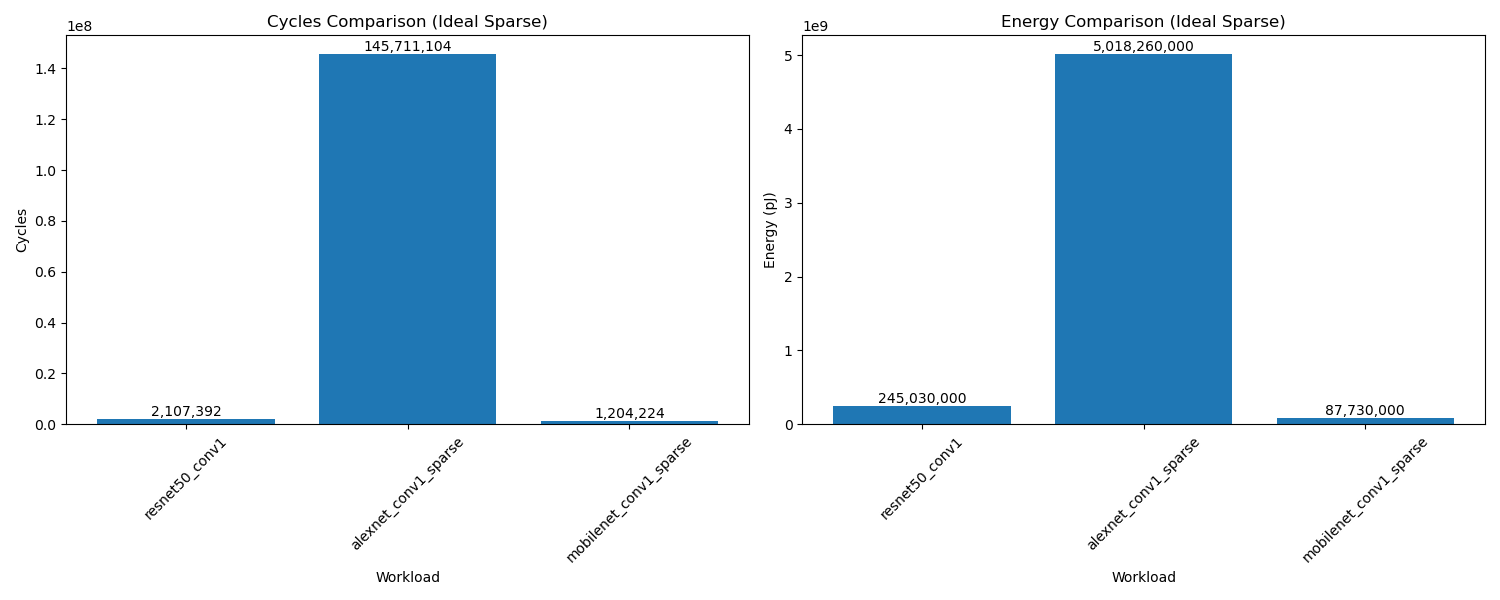

In [349]:
    from IPython.display import Image
    import matplotlib.pyplot as plt

    # Define path to the figure using the relative path
    ideal_comparison_fig = "../evaluation_setups/unstructured_sparse_eval/outputs/figures/ideal_comparison.png"

    # Display the image directly using IPython's Image display
    Image(filename=ideal_comparison_fig)

In [350]:
import pandas as pd
import numpy as np
import sys
import os
import re
import matplotlib.pyplot as plt

# Function to parse stats directly from the text file
def parse_stats_file(stats_file):
    if not os.path.exists(stats_file):
        print(f"Warning: Stats file not found: {stats_file}")
        return None
    
    stats = {'level_energy': {}}
    try:
        with open(stats_file, 'r') as f:
            content = f.read()
            
            # --- Fix 1: Extract total energy from Summary Stats --- 
            # Look for "Energy: VALUE uJ" in the Summary Stats section
            summary_energy_match = re.search(r'Summary Stats\n-{3,}\n.*?Energy:\s+([\d.]+)\s+uJ', content, re.DOTALL)
            if summary_energy_match:
                stats['energy'] = float(summary_energy_match.group(1)) * 1_000_000 # Convert uJ to pJ
            else:
                # Fallback: Try finding any "Energy (total)" line if summary is missing (less reliable)
                energy_match = re.search(r'Energy \(total\)\s+:\s+([\d.]+)', content)
                if energy_match:
                    print(f"Warning: Using fallback total energy parsing for {stats_file}")
                    stats['energy'] = float(energy_match.group(1))
                else:
                    print(f"Error: Could not parse total energy from {stats_file}")
                    stats['energy'] = 0 # Assign 0 if unparsable

            # Extract cycles (Prefer summary stats if available)
            summary_cycles_match = re.search(r'Summary Stats\n-{3,}\n.*?Cycles:\s+(\d+)', content, re.DOTALL)
            if summary_cycles_match:
                stats['cycles'] = int(summary_cycles_match.group(1))
            else:
                # Fallback to first Cycles match
                cycles_match = re.search(r'Cycles\s+:\s+(\d+)', content)
                if cycles_match:
                     print(f"Warning: Using fallback cycles parsing for {stats_file}")
                     stats['cycles'] = int(cycles_match.group(1))
                else:
                     stats['cycles'] = 0


            # Extract utilization (Prefer summary stats: 0.0-1.0 scale)
            summary_util_match = re.search(r'Summary Stats\n-{3,}\n.*?Utilization:\s+([\d.]+)', content, re.DOTALL)
            if summary_util_match:
                # Convert utilization (0.0-1.0) to percentage for display consistency
                stats['utilization'] = float(summary_util_match.group(1)) 
            else:
                # Fallback: MAC level utilization (Average instances)
                # This requires knowing total instances to be meaningful %
                util_match = re.search(r'Level 0\n-{3,}\n=== MAC ===.*?Utilized instances \(average\)\s+:\s+([\d.]+)', content, re.DOTALL)
                if util_match:
                     print(f"Warning: Using fallback MAC utilization for {stats_file}. Value is avg instances, not percentage.")
                     # Store the average instance count, not a percentage
                     stats['utilization'] = float(util_match.group(1)) 
                else:
                    stats['utilization'] = 0
                
            # --- Fix 2: Extract per-level energy, summing across tensors --- 
            # Regex to capture content between "Level X..." and the next "Level Y..." or end of file
            level_pattern = r'(Level\s+(\d+)\n-{3,}\n=== ([^\n]+) ===.*?)(?=(Level\s+\d+\n-{3,})|\Z)'
            level_matches = re.finditer(level_pattern, content, re.DOTALL)
            
            level_energy = {}
            parsed_sum = 0.0
            for match in level_matches:
                level_full_header = match.group(1).strip() # Includes "Level X..." etc.
                level_num = int(match.group(2))
                level_name = match.group(3).strip()
                # Content is the full block captured by group 1
                level_content = match.group(1) 
                
                # Find *all* "Energy (total) : VALUE pJ" lines within this level's block
                energy_values = re.findall(r'Energy \(total\)\s+:\s+([\d.]+) pJ', level_content)
                
                # Sum up all found energy values for this level
                total_level_energy = sum(float(e.replace(',', '')) for e in energy_values) # Handle potential commas
                
                level_key = f"L{level_num}_{level_name}"
                if total_level_energy > 0:
                     level_energy[level_key] = total_level_energy
                     parsed_sum += total_level_energy
                # If a level exists but has 0 energy reported, we might want to record that
                elif level_full_header: # Check if the level header was actually found
                     level_energy[level_key] = 0.0

            stats['level_energy'] = level_energy
                
        # Add a simple validation check
        if stats['energy'] > 0 and not np.isclose(parsed_sum, stats['energy'], rtol=0.1): # Allow 10% tolerance for potential rounding
             print(f"Warning: Sum of parsed level energies ({parsed_sum:,.2f} pJ) doesn't closely match total summary energy ({stats['energy']:,.2f} pJ) for {stats_file}. Check parsing logic or stats file format.")
        elif stats['energy'] == 0 and parsed_sum > 0:
             print(f"Warning: Total summary energy is 0, but parsed level energy sum is {parsed_sum:,.2f} pJ for {stats_file}.")


        return stats
    except Exception as e:
        print(f"Critical Error parsing {stats_file}: {e}")
        # Consider logging the error traceback here
        return None

# Load and process the results for both architectures
workloads = ["resnet50_conv1", "alexnet_conv1_sparse", "mobilenet_conv1_sparse"]
workload_display_names = {'resnet50_conv1': 'ResNet-50', 
                          'alexnet_conv1_sparse': 'AlexNet', 
                          'mobilenet_conv1_sparse': 'MobileNet'}

unstructured_results = {}
ideal_results = {}

for workload in workloads:
    # Unstructured sparse architecture results
    unstructured_stats_file = f"../evaluation_setups/unstructured_sparse_eval/outputs/unstructured_{workload}/timeloop-mapper.stats.txt"
    stats = parse_stats_file(unstructured_stats_file)
    if stats:
        unstructured_results[workload] = stats
    
    # Ideal sparse architecture results
    ideal_stats_file = f"../evaluation_setups/unstructured_sparse_eval/outputs/ideal_{workload}/timeloop-mapper.stats.txt"
    stats = parse_stats_file(ideal_stats_file)
    if stats:
        ideal_results[workload] = stats

# Create DataFrames for comparison
def create_dataframe(results, workloads):
    data = []
    for workload in workloads:
        if workload in results:
            row = {
                'Workload': workload_display_names[workload],
                'Cycles': results[workload].get('cycles', 0),
                'Energy (pJ)': results[workload].get('energy', 0),
                'Utilization (%)': results[workload].get('utilization', 0) * 100  # Convert to percentage
            }
            data.append(row)
    return pd.DataFrame(data)

unstructured_df = create_dataframe(unstructured_results, workloads)
ideal_df = create_dataframe(ideal_results, workloads)

# Calculate improvement ratios
if not unstructured_df.empty and not ideal_df.empty:
    # Make sure both dataframes have the same workloads
    common_workloads = set(unstructured_df['Workload']).intersection(set(ideal_df['Workload']))
    unstructured_filtered = unstructured_df[unstructured_df['Workload'].isin(common_workloads)]
    ideal_filtered = ideal_df[ideal_df['Workload'].isin(common_workloads)]
    
    # Sort both DataFrames by workload to ensure they match
    unstructured_filtered = unstructured_filtered.sort_values('Workload').reset_index(drop=True)
    ideal_filtered = ideal_filtered.sort_values('Workload').reset_index(drop=True)
    
    comparison_df = pd.DataFrame({
        'Workload': unstructured_filtered['Workload'],
        'Cycle Ratio (Unstructured/Ideal)': unstructured_filtered['Cycles'] / ideal_filtered['Cycles'].replace(0, np.nan),
        'Energy Ratio (Unstructured/Ideal)': unstructured_filtered['Energy (pJ)'] / ideal_filtered['Energy (pJ)'].replace(0, np.nan),
        'Utilization Ratio (Ideal/Unstructured)': ideal_filtered['Utilization (%)'] / unstructured_filtered['Utilization (%)'].replace(0, np.nan)
    })
else:
    comparison_df = pd.DataFrame(columns=['Workload', 'Cycle Ratio (Unstructured/Ideal)', 
                                          'Energy Ratio (Unstructured/Ideal)', 'Utilization Ratio (Ideal/Unstructured)'])

# Energy breakdown by hardware level
print("Energy Breakdown by Hardware Level:")
print("=" * 60)

for arch_name, results in [('Unstructured', unstructured_results), ('Ideal', ideal_results)]:
    print(f"\n{arch_name} Architecture:")
    
    for workload in workloads:
        if workload in results and 'level_energy' in results[workload]:
            level_energy = results[workload]['level_energy']
            total_energy = results[workload].get('energy', 0)
            
            if level_energy and total_energy > 0:
                print(f"\n{workload_display_names[workload]}:")
                
                for level, energy in level_energy.items():
                    percentage = (energy / total_energy) * 100
                    print(f"  {level}: {energy:,.2f} pJ ({percentage:.2f}%)")
            else:
                print(f"\n{workload_display_names[workload]}: Energy breakdown not available")

# Display the summary analysis
print("\nPerformance Comparison: Unstructured vs Ideal")
print("=" * 60)
print("Unstructured Sparse Architecture:")
if not unstructured_df.empty:
    print(unstructured_df.to_string(index=False))
else:
    print("No data available")

print("\nIdeal Sparse Architecture:")
if not ideal_df.empty:
    print(ideal_df.to_string(index=False))
else:
    print("No data available")

print("\nImprovement Ratios:")
if not comparison_df.empty:
    print(comparison_df.to_string(index=False))
else:
    print("No data available for comparison")

print("\nKey Observations:")
print("-" * 60)

if not comparison_df.empty:
    # Filter out NaN and infinity values
    cycle_ratios = comparison_df['Cycle Ratio (Unstructured/Ideal)'].replace([np.inf, -np.inf], np.nan).dropna()
    energy_ratios = comparison_df['Energy Ratio (Unstructured/Ideal)'].replace([np.inf, -np.inf], np.nan).dropna()
    
    if not cycle_ratios.empty:
        avg_cycle_ratio = cycle_ratios.mean()
        print(f"1. Average cycle overhead from sparse metadata: {avg_cycle_ratio:.2f}x")
    else:
        print("1. Cannot calculate average cycle overhead (insufficient data)")
    
    if not energy_ratios.empty:
        avg_energy_ratio = energy_ratios.mean()
        print(f"2. Average energy overhead from sparse metadata: {avg_energy_ratio:.2f}x")
    else:
        print("2. Cannot calculate average energy overhead (insufficient data)")
    
    print("\n3. Workload-Specific Impact:")
    for _, row in comparison_df.iterrows():
        cycle_ratio = row['Cycle Ratio (Unstructured/Ideal)']
        energy_ratio = row['Energy Ratio (Unstructured/Ideal)']
        
        result_str = f"   - {row['Workload']}: "
        if not pd.isna(cycle_ratio) and not np.isinf(cycle_ratio):
            result_str += f"{cycle_ratio:.2f}x cycle overhead, "
        else:
            result_str += "cycle data unavailable, "
            
        if not pd.isna(energy_ratio) and not np.isinf(energy_ratio):
            result_str += f"{energy_ratio:.2f}x energy overhead"
        else:
            result_str += "energy data unavailable"
            
        print(result_str)
else:
    print("Not enough data available for meaningful observations")

print("\n4. Recommendations for Hardware Optimization:")
print("   - Optimize hardware for sparse metadata handling to reduce cycle and energy overhead")
print("   - Focus optimizations on memory levels with highest energy consumption")
print("   - Consider workload-specific accelerator configurations based on observed patterns")

Energy Breakdown by Hardware Level:

Unstructured Architecture:

ResNet-50:
  L0_MAC: 52,738,074.87 pJ (11.85%)
  L1_LRF: 0.00 pJ (0.00%)
  L2_RF: 186,754,438.36 pJ (41.96%)
  L3_SMEM: 174,563,655.04 pJ (39.22%)
  L4_DRAM: 31,025,664.00 pJ (6.97%)

AlexNet:
  L0_MAC: 195,346,134.47 pJ (3.75%)
  L1_LRF: 0.00 pJ (0.00%)
  L2_RF: 0.00 pJ (0.00%)
  L3_SMEM: 4,958,119,912.26 pJ (95.10%)
  L4_DRAM: 60,141,056.00 pJ (1.15%)

MobileNet:
  L0_MAC: 4,843,292.59 pJ (5.23%)
  L1_LRF: 0.00 pJ (0.00%)
  L2_RF: 17,150,917.81 pJ (18.53%)
  L3_SMEM: 56,457,443.04 pJ (60.99%)
  L4_DRAM: 14,120,448.00 pJ (15.25%)

Ideal Architecture:

ResNet-50:
  L0_MAC: 0.00 pJ (0.00%)
  L1_LRF: 1,437,048.95 pJ (0.59%)
  L2_RF: 44,834.91 pJ (0.02%)
  L3_SMEM: 212,522,206.92 pJ (86.73%)
  L4_DRAM: 31,025,664.00 pJ (12.66%)

AlexNet:
  L0_MAC: 0.00 pJ (0.00%)
  L1_LRF: 0.00 pJ (0.00%)
  L2_RF: 0.00 pJ (0.00%)
  L3_SMEM: 4,958,119,912.26 pJ (98.80%)
  L4_DRAM: 60,141,056.00 pJ (1.20%)

MobileNet:
  L0_MAC: 0.00 pJ (0.00%)